<a href="https://colab.research.google.com/github/KukovecRok/AlexNet_inefficient_using_NiaPy/blob/main/NiaPyDiplomskaColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predpogoj - mount gDrive

In [1]:
# Potrebni importi
import os
import torch
import torch.nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F 
import torchvision.utils as utils
import cv2 
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image
import argparse
import PIL.Image
import pandas as pd
import glob
from pathlib import Path
import time
from numpy import asarray

In [2]:
alexnet = models.alexnet(pretrained=True)
alexnet.eval()

def napovejSlike(slika, alexnet):
   # Obdelava velikosti slike
    data_transforms = transforms.Compose([
        transforms.Resize((224,224)),       # Nastavi velikost sičic 224x224
        transforms.ToTensor(),              # Input na Tensorjev format
        transforms.Normalize( # Normalizacija
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )])
    # Odpiranje slik
    transformed_img = data_transforms(slika) # Klicanje funkcije za obdelavo velikosti slik(e)
    batch_img = torch.unsqueeze(transformed_img, 0)
    
    output = alexnet(batch_img)

    sorted, indices = torch.sort(output, descending=True)
    percentage = F.softmax(output, dim=1)[0] * 100.0 
    
    return indices, percentage

In [3]:
!pip install NiaPy==2.0.0rc12

# Ob prvem zagonu - prenos datotek!!

In [4]:
# Prenos datotek 
# nastaviti po potrebi

# Slika tigra
#!wget https://raw.githubusercontent.com/KukovecRok/AlexNet_inefficient_using_NiaPy/main/tiger.jpg?token=AICPP3G6CVDURQURGKPDCQDAFVQYY
# Labels
#!wget https://raw.githubusercontent.com/KukovecRok/AlexNet_inefficient_using_NiaPy/main/ILVRSC%20ImageNet%20Labels/class_names_ImageNet.txt?token=AICPP3GEEVNB4SKMSAJBD4DAFVRUE
# Rename (delete ?token=...)

originalSlika = cv2.imread('./tiger.jpg')

In [5]:
def imgTO1d(img):
    oblika = img.shape
    img = img.reshape(-1)
    testko = [i / 255 for i in img] # Shrani prvoten shape slike
    return oblika, testko

def imgFROM1d(testko, oblika):
    testkoDva = [int(i * 255) for i in testko]
    testkoDva = np.asarray(testkoDva)
    testkoDva = testkoDva.reshape(oblika)
    return testkoDva

In [6]:
from NiaPy.algorithms.basic.pso import ParticleSwarmAlgorithm
from NiaPy.benchmarks import Benchmark
from NiaPy.task.task import OptimizationType, StoppingTask

class TestBenchmark(Benchmark):

    def __init__(self, iskanje):
        self.Lower = 0
        self.Upper = 1
        super().__init__(self.Lower, self.Upper)

        self.iskanje = iskanje

    def function(self):
        def evaluate(D, solution):
            # print(f'D: {D}')
            # print(f'solution: {solution}')

            razlika = 0
            for i in range(D):
                razlika = razlika + abs(iskanje[i] - solution[i])

            return razlika

        return evaluate

if __name__ == "__main__":

    oblika, iskanjeSlika = imgTO1d(originalSlika)

    algoritem = ParticleSwarmAlgorithm(NP=10)

    n = 63075
    test = np.empty(n, dtype=object)
    iskanje = np.empty(3, dtype=object)
    
    for i in range(21025):
        i *= 3
        
        iskanje[0] = iskanjeSlika[i]
        iskanje[1] = iskanjeSlika[i+1]
        iskanje[2] = iskanjeSlika[i+2]
    
        benchm = TestBenchmark(iskanje=iskanje)
        task = StoppingTask(D=len(iskanje),
                            nFES=20,
                            optType=OptimizationType.MINIMIZATION,
                            benchmark=benchm)

        resitev, fitness = algoritem.run(task=task)
        test[i] = resitev[0]
        test[i+1] = resitev[1]
        test[i+2] = resitev[2]

    print("iskanje: ", iskanje)
    print("resitev: ", resitev)
    print("fitness: ", fitness)

ISKANJE:  [0.22745098039215686 0.2627450980392157 0.39215686274509803]
resitev:  [0.5137214  0.23228838 0.46540781]
fitness:  0.3899780884612056


In [7]:
oblikaTiger, iskanjeSlika = imgTO1d(originalSlika)

algoritem = ParticleSwarmAlgorithm(NP=20)  

n = len(iskanjeSlika)
rangeFor = (int(n / 9))

resitevTiger = np.empty(n, dtype=object)
iskanje = np.empty(9, dtype=object)
    
for i in range(rangeFor):
    i *= 9
    for j in range (9):
        iskanje[j] = iskanjeSlika[i+j]
    
    benchm = TestBenchmark(iskanje=iskanje)
    task = StoppingTask(D=len(iskanje),
                        nFES=70,
                        optType=OptimizationType.MINIMIZATION,
                        benchmark=benchm)

    resitev, fitness = algoritem.run(task=task)

    for j in range (9):
        resitevTiger[i+j] = resitev[j]

# Celotna slika --> 1d array pri NP=10.000 in nFES=100.000: "Vaša seja se je zrušila, ko ste porabili ves razpoložljivi RAM. ", rezultat pa zanič, priložen v GitHubu, ./NiaPy images/*.png

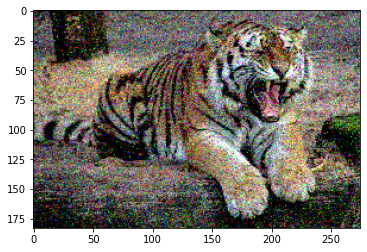

Naš napovedan razred: lion, king of beasts, Panthera leo 
Algoritem to trdi z zagotovostvjo 26.53%


In [8]:
resitevTiger = imgFROM1d(resitevTiger, oblikaTiger)
plt.imshow(resitevTiger[...,::-1])
plt.show()

PIL_image = PIL.Image.fromarray(np.uint8(resitevTiger)).convert('RGB')

indices, percentage = napovejSlike(PIL_image, alexnet)

with open('./class_names_ImageNet.txt') as labels:
    classes = [i.strip() for i in labels.readlines()]

    results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
    print('Naš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')

# Spreminjanje samo dela slike?

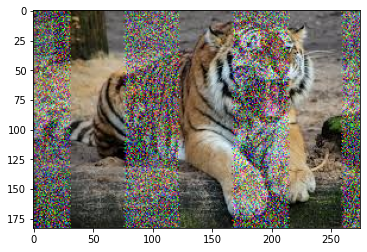

Naš napovedan razred: missile 
Algoritem to trdi z zagotovostvjo 8.73%


In [15]:
oblika, iskanjeSlika = imgTO1d(originalSlika)

algoritem = ParticleSwarmAlgorithm(NP=10)  

n = len(iskanjeSlika)
rangeFor = (int(n / 9))

iskanjeTiger = np.empty(n, dtype=object)
iskanje = np.empty(9, dtype=object)
    
for i in range(rangeFor):
    i *= 9
    for j in range (9):
        iskanje[j] = iskanjeSlika[i+j]
    if ( ( (i % 275) > 0) & ( (i % 275) < 90) | ( (i % 275) < 275) & ( (i % 275) > 225) ):
        benchm = TestBenchmark(iskanje=iskanje)
        task = StoppingTask(D=len(iskanje),
                          nFES=15,
                          optType=OptimizationType.MINIMIZATION,
                          benchmark=benchm)

        resitev, fitness = algoritem.run(task=task)

        for j in range (9):
            iskanjeTiger[i+j] = resitev[j]
    else:
        for j in range (9):
            iskanjeTiger[i+j] = iskanjeSlika[i+j]


resitevTigerDva = imgFROM1d(iskanjeTiger, oblika)
plt.imshow(resitevTigerDva[...,::-1])
plt.show()

# CNN Klasifikacija se opravi v Colab, PyTorch ima par GB + model ~ 300MB + slike ~ 6GB ...

PIL_image = PIL.Image.fromarray(np.uint8(resitevTigerDva)).convert('RGB')

indices, percentage = napovejSlike(PIL_image, alexnet)

with open('./class_names_ImageNet.txt') as labels:
    classes = [i.strip() for i in labels.readlines()]

    results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
    print('Naš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')